### ZIFA
##### 01Apr19
Testing [Zero-Inflated Factor Analysis (ZIFA)](https://github.com/epierson9/ZIFA) on datasets to compare to prior DR techniques.

In [44]:
import sys
sys.path.append('../')
from fcc_DRs import *
from fcc_utils import *
%matplotlib inline

In [2]:
from ZIFA import ZIFA
from ZIFA import block_ZIFA

In [79]:
# reload functions when editing file
del sys.modules['fcc_DRs']
from fcc_DRs import *

---
#### 0. read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [3]:
P14Retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1, labels=[0,0])

In [4]:
P14Retina.data.shape

(6600, 20478)

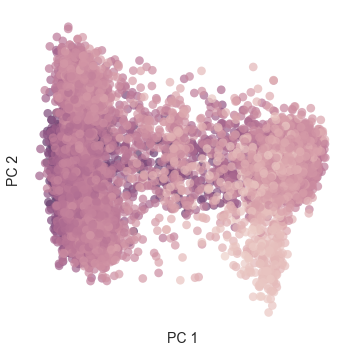

In [5]:
P14Retina_PCA100 = fcc_PCA(P14Retina.arcsinh_norm(norm='l1'), n_components=100)
P14Retina_PCA100.plot()

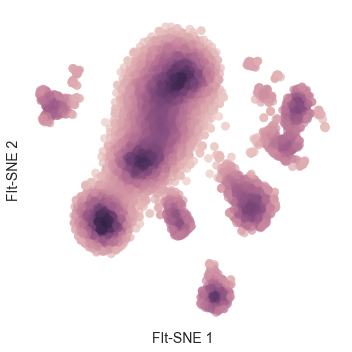

CPU times: user 3.12 s, sys: 233 ms, total: 3.36 s
Wall time: 23.6 s


In [6]:
%%time 
P14Retina_tSNE = fcc_FItSNE(P14Retina_PCA100.results, perplexity=30, seed=10) # use standard perplexity of 30 here
P14Retina_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1331437f0>)

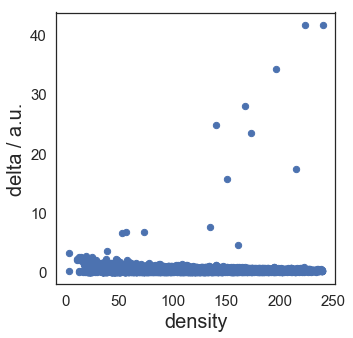

In [7]:
P14Retina_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x132828358>)

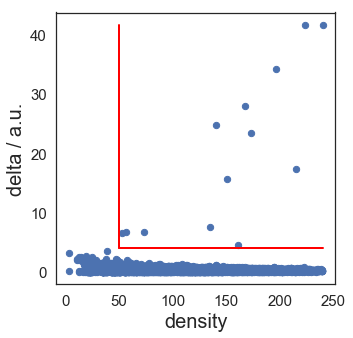

In [8]:
P14Retina_tSNE.clu.assign(50,4) # assign cluster center cutoffs
P14Retina_tSNE.clu.draw_decision_graph(min_delta=P14Retina_tSNE.clu.min_delta, min_density=P14Retina_tSNE.clu.min_density) # plot chosen density-peak cluster centers

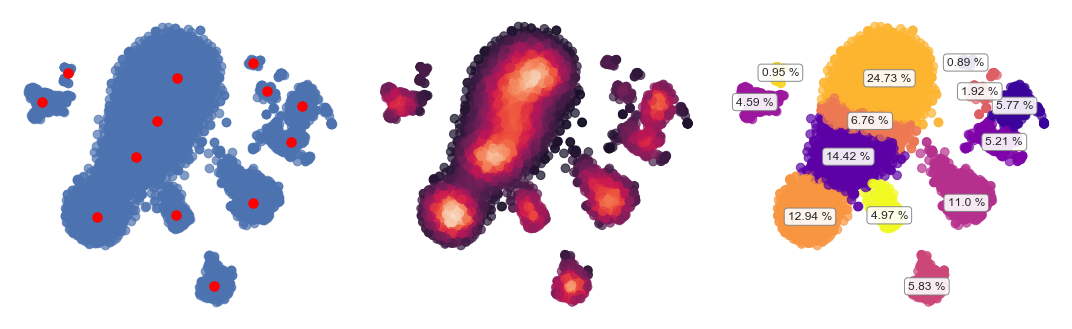

In [9]:
P14Retina_tSNE.plot_clusters() # visualize clustering

In [10]:
print('Silhouette Score: {}\n'.format(P14Retina_tSNE.silhouette_score()))

Silhouette Score: 0.4567716096602183



In [11]:
# select 500 most variable genes
P14Retina_varselect = RNA_counts.var_select(P14Retina, n_features=500) 

In [12]:
# choose 1000 cells with proportional representation from clusters above
P14Retina_0 = RNA_counts.downsample_proportional(P14Retina_varselect, P14Retina_tSNE.clu.membership, n_cells=1000, seed=10)

Perform __ZIFA__ on downsampled, feature-selected dataset

In [13]:
%time Z, model_params = block_ZIFA.fitModel(P14Retina_0.log2_norm(), K=2)

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1007, D = 480, K = 2, n_blocks = 1
Block sizes [480]
Param change below threshold 1.000e-02 after 5 iterations
CPU times: user 1min 14s, sys: 11.3 s, total: 1min 26s
Wall time: 44.6 s


In [14]:
Z_clu = Cluster(Z.astype('double'), autoplot=False) # get density-peak cluster information for results to use for plotting

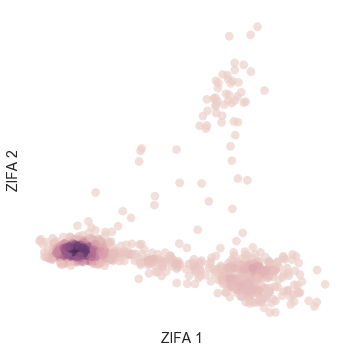

In [15]:
plt.figure(figsize=(5,5))
sns.scatterplot(Z[:,0], Z[:,1], s=75, alpha=0.7, hue=Z_clu.density, legend=None, edgecolor='none')
plt.xlabel('ZIFA 1', fontsize=14)
plt.ylabel('ZIFA 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

---
#### Compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs

In [16]:
k = 30 # choose value for K-nearest neighbor calculations

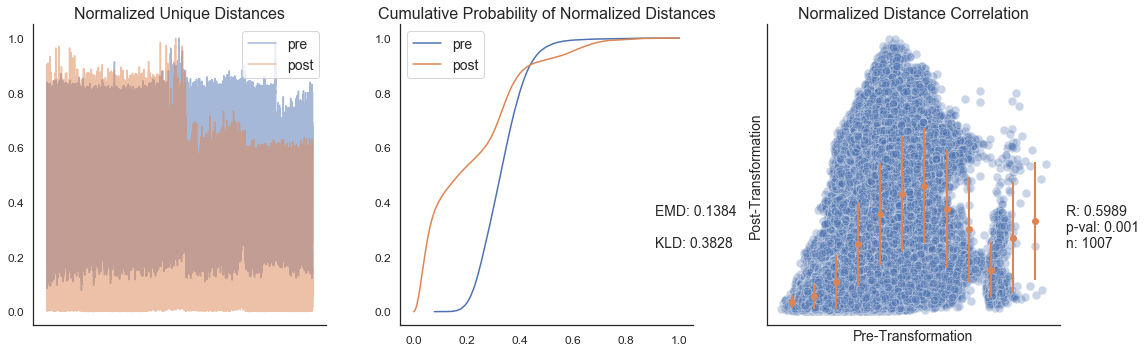

Knn Preservation: 94.9783

CPU times: user 29.5 s, sys: 4.94 s, total: 34.4 s
Wall time: 34 s


In [17]:
%%time
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='log2'), 
                                  post=sc.spatial.distance_matrix(Z, Z))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='log2'), 
                                                       post=kneighbors_graph(sc.spatial.distance_matrix(Z, Z), k, mode='connectivity', include_self=False).toarray())))

---
#### Use scVI to reduce dimensions

In [32]:
from scvi.dataset import AnnDataset, CsvDataset
import urllib
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
n_epochs=400 
lr=1e-3
use_batches=False
use_cuda=True

In [28]:
P14Retina_adata = scanpy.AnnData(P14Retina_0.data)
P14Retina_adata.write('P14Retina_0.h5ad')

In [29]:
P14Retina_adata.X

array([[  7.,   0.,   4., ...,   0.,   0.,   2.],
       [128.,   4.,  74., ...,  10.,   1.,  14.],
       [  8.,   0.,   5., ...,   1.,   0.,   1.],
       ...,
       [ 54.,  12.,  21., ...,   1.,   0.,   0.],
       [ 21.,   5.,  11., ...,   1.,   0.,   1.],
       [  0.,   2., 114., ...,   0.,   0.,   0.]], dtype=float32)

In [33]:
# Loading a local dataset into scVI
P14Retina1_scVI = CsvDataset('GSM1626793_P14Retina_1.digital_expression.csv.gz', 
                               save_path='../inputs/', compression='gzip') 

File ../inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 20478 to 600 genes
Downsampling from 6600 to 6600 cells


In [34]:
vae = VAE(P14Retina1_scVI.nb_genes, n_batch=P14Retina1_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              P14Retina1_scVI,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [09:16<00:00,  1.40s/it]


/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


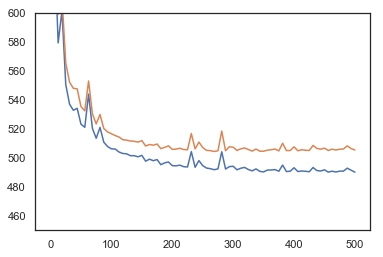

In [35]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,500,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.ylim(450,600)
plt.show()

In [36]:
P14Retina1_scVI_results = RNA_counts(trainer.train_set.get_latent()[0], labels=[None, None])

In [37]:
P14Retina1_scVI_results_tSNE = fcc_FItSNE(matrix=P14Retina1_scVI_results.counts, perplexity=30, seed=10)

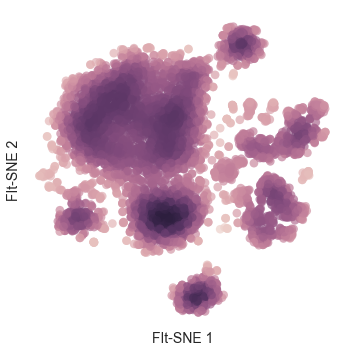

In [45]:
P14Retina1_scVI_results_tSNE.plot()

In [39]:
list(trainer.gene_dataset.gene_names)

['19:5795690-5802672:Malat1',
 '6:115931927-115938829:Rho',
 'MT:1094-2675:mt-Rnr2',
 '6:3993797-3997436:Gngt1',
 '12:100199435-100209806:Calm1',
 '1:87803680-87845158:Sag',
 '12:109541001-109571726:Meg3',
 'MT:14145-15288:mt-Cytb',
 '2:158375638-158386145:Snhg11',
 '7:103826534-103828096:Hbb-bs',
 '1:150319417-150333905:Pdc',
 '13:99898484-99900683:Cartpt',
 '1:164437267-164458355:Atp1b1',
 '14:68083863-68089095:Nefl',
 '11:120447605-120453500:Pde6g',
 '7:64153835-64269775:Trpm1',
 '16:96467606-96525793:Pcp4',
 '2:136713453-136782428:Snap25',
 'MT:2751-3707:mt-Nd1',
 '9:107674477-107679592:Gnat1',
 '14:52110704-52163546:Rpgrip1',
 '12:85473890-85477273:Fos',
 '7:19696109-19699166:Apoe',
 '11:67695326-67703333:Rcvrn',
 '10:108497650-109010982:Syt1',
 '3:51388415-51396738:Mgarp',
 '1:153899944-153909723:Glul',
 '8:46206797-46211284:Slc25a4',
 '17:46910459-46924933:Prph2',
 '2:174284320-174346744:Gnas',
 '1:4343507-4360314:Rp1',
 '4:155491361-155559269:Gnb1',
 '8:110142539-110168206:Calb

In [46]:
trainer.train_set.indices.shape

(4950,)

In [47]:
# subset original data for cells selected by scVI
P14Retina_scVIselect = RNA_counts.keep_set(counts_obj=P14Retina, keep_index=trainer.train_set.indices, axis=0, num=True)

In [48]:
# subset original data for genes selected by scVI
P14Retina_scVIselect = RNA_counts.keep_set(counts_obj=P14Retina_scVIselect, keep_index=trainer.gene_dataset.gene_names, axis=1)

In [49]:
P14Retina_scVIselect.data.shape # check for proper shape

(4950, 600)

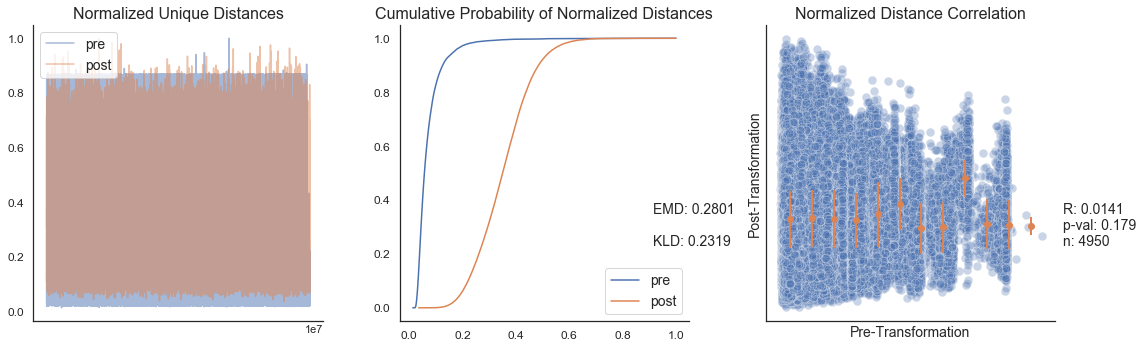

Knn Preservation: 98.7956

CPU times: user 23min 43s, sys: 5min 33s, total: 29min 16s
Wall time: 29min 42s


In [89]:
%%time
# transform==none for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_scVIselect.distance_matrix(), 
                                  post=P14Retina1_scVI_results.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_scVIselect.knn_graph(k), 
                                                       post=P14Retina1_scVI_results.knn_graph(k))))